In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from numba import cuda, int64
from timeit import default_timer as timer
import simple

In [28]:
def get_df(times: list[int], samples: int):
    if len(times) < samples - 2:
        return "----"
    return str(round((np.sum(times) - min(times) - max(times)) / (samples - 2) * 1000, 2)).replace(".",",")


def get_test_tracks(len: int, track: np.array) -> tuple[int, np.array, np.array]:
    return offset, track[:len]

def comp_tracks(a: np.array, b: np.array) -> int:
    return np.sum(np.abs(np.subtract(a, b)))

def calc_cpu(a: np.array, b: np.array) -> int:
    return np.argmin(np.array([comp_tracks(a, b[i:(i + 1024)]) for i in range(len(b) - 1024)]))

@cuda.jit(device=True)
def diff(a, b):
    return abs(a - b)

@cuda.jit
def calc_gpu(offset, track, res):
    off = cuda.blockIdx.x + cuda.blockIdx.y * cuda.gridDim.y
    t_idx = cuda.threadIdx.x + cuda.threadIdx.y * cuda.blockDim.y

    if off >= res.shape[0] or t_idx >= track.shape[0]:
        return

    res[off, t_idx] = diff(offset[t_idx], track[off + t_idx])

@cuda.jit
def calc_gpu_shared(offset, track, res):
    off = cuda.blockIdx.x + cuda.blockIdx.y * cuda.gridDim.y
    t_idx = cuda.threadIdx.x + cuda.threadIdx.y * cuda.blockDim.y

    if off >= res.shape[0] or t_idx >= track.shape[0]:
        return

    sharedMem = cuda.shared.array(shape=(1), dtype=int64)
    if t_idx == 0:
        sharedMem[0] = 0
    
    cuda.syncthreads()
    cuda.atomic.add(sharedMem, 0, diff(offset[t_idx], track[off + t_idx]))
    cuda.syncthreads()

    if t_idx == 0:
        res[off] = sharedMem[0]

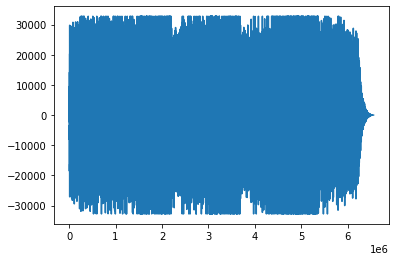

In [31]:
original = simple.load_sound_files()[0]
original.data = original.data[10000:]
plt.plot(original.data)
test_data = { int(size): { "offset": original.data[1024:2048], "track": original.data[0:int(size)] } for size in [5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5]}

In [36]:
samples = 12
results = {}

for size, data in test_data.items():
    times = []
    for i in range(samples):
        start = timer()
        res = calc_cpu(data["offset"], data["track"])
        end = timer()
        if res != 1024:
            print(f"Bad value for size: {size}")
            break;
        times.append(end - start)
    print(f"{size:>8} = {get_df(times, samples):>8}ms")

    5000 =    30,93ms
   10000 =    70,25ms
   20000 =   149,35ms
   50000 =   389,72ms
  100000 =   774,47ms
  200000 =  1550,99ms
  500000 =  3885,11ms


In [37]:
threads_per_block = (32, 32)
block_size = int(np.ceil(np.sqrt(original.len - 1024)))
blocks_per_grid = (block_size, block_size)

samples = 13

for size, data in test_data.items():
    times = []
    for i in range(samples):
        start = timer()
        offset_gpu = cuda.to_device(data["offset"])
        track_gpu = cuda.to_device(data["track"])
        res_gpu = cuda.to_device(np.zeros((len(data["track"]) - 1024, 1024), dtype=np.int16))
        calc_gpu[blocks_per_grid, threads_per_block](offset_gpu, track_gpu, res_gpu)
        arg = np.argmin(np.sum(res_gpu.copy_to_host(), axis=1))
        end = timer()
        if i == 0:
            continue

        if res != 1024:
            print(f"Bad value for size: {size}")
            break;
        times.append(end - start)
    print(f"{size:>8} = {get_df(times, samples - 1):>8}ms")


    5000 =   178,68ms
   10000 =    188,2ms
   20000 =   209,76ms
   50000 =   269,35ms
  100000 =   370,28ms
  200000 =   568,66ms
  500000 =  1167,35ms


In [35]:
threads_per_block = (32, 32)
block_size = int(np.ceil(np.sqrt(original.len - 1024)))
blocks_per_grid = (block_size, block_size)

samples = 4

for size, data in test_data.items():
    times = []
    for i in range(samples):
        start = timer()
        offset_gpu = cuda.to_device(data["offset"])
        track_gpu = cuda.to_device(data["track"])
        res_gpu = cuda.to_device(np.zeros((len(data["track"]) - 1024), dtype=np.int16))
        calc_gpu_shared[blocks_per_grid, threads_per_block](offset_gpu, track_gpu, res_gpu)
        arg = np.argmin(res_gpu.copy_to_host())
        end = timer()
        if i == 0:
            continue

        if res != 1024:
            print(f"Bad value for size: {size}")
            break;
        times.append(end - start)
    print(f"{size:>8} = {get_df(times, samples - 1):>8}ms")

    5000 =   342,96ms
   10000 =   560,13ms
   20000 =    992,3ms
   50000 =  2291,14ms
  100000 =  4456,26ms
  200000 =  8786,98ms
  500000 = 21902,83ms
